In [1]:
import re
import requests
import numpy as np
import networkx as nx


r=requests.get('http://map.amap.com/service/subway?_1469083453978&srhdata=1100_drw_beijing.json')
s1=r.text
places=re.findall('"n":"(\w+)"',r.text)
lat_lon=re.findall('"sl":"(\d+\.\d+,\d+\.\d+)"',r.text)
print(lat_lon)
stations_info={}
for i in range(len(places)):
    place_name=re.findall('"n":"(\w+)"', places[i])[0]
    stations_info[place_name]=tuple(map(float, lat_lon[i].split(',')))
#stations_info

[u'116.163167,39.923620', u'116.134010,39.916030', u'116.125809,39.912383', u'116.122225,39.905138', u'116.123254,39.895780', u'116.114443,39.890465', u'116.100334,39.889378', u'116.177388,39.926727', u'116.190337,39.907450', u'116.212684,39.907442', u'116.235948,39.907440', u'116.252888,39.907433', u'116.273987,39.907456', u'116.294765,39.907474', u'116.309919,39.907469', u'116.321459,39.907422', u'116.337583,39.907379', u'116.352583,39.907234', u'116.356866,39.907242', u'116.374072,39.907383', u'116.391278,39.907472', u'116.401216,39.907780', u'116.411571,39.908069', u'116.418480,39.908325', u'116.435806,39.908501', u'116.450497,39.908454', u'116.461841,39.909104', u'116.475783,39.908287', u'116.495456,39.908749', u'116.515664,39.908495', u'116.373126,39.948653', u'116.393776,39.948972', u'116.408240,39.949180', u'116.417069,39.949336', u'116.435842,39.941626', u'116.434133,39.933801', u'116.434584,39.924499', u'116.435806,39.908501', u'116.427287,39.904983', u'116.417093,39.901063',

KeyError: u'\u9a6c'

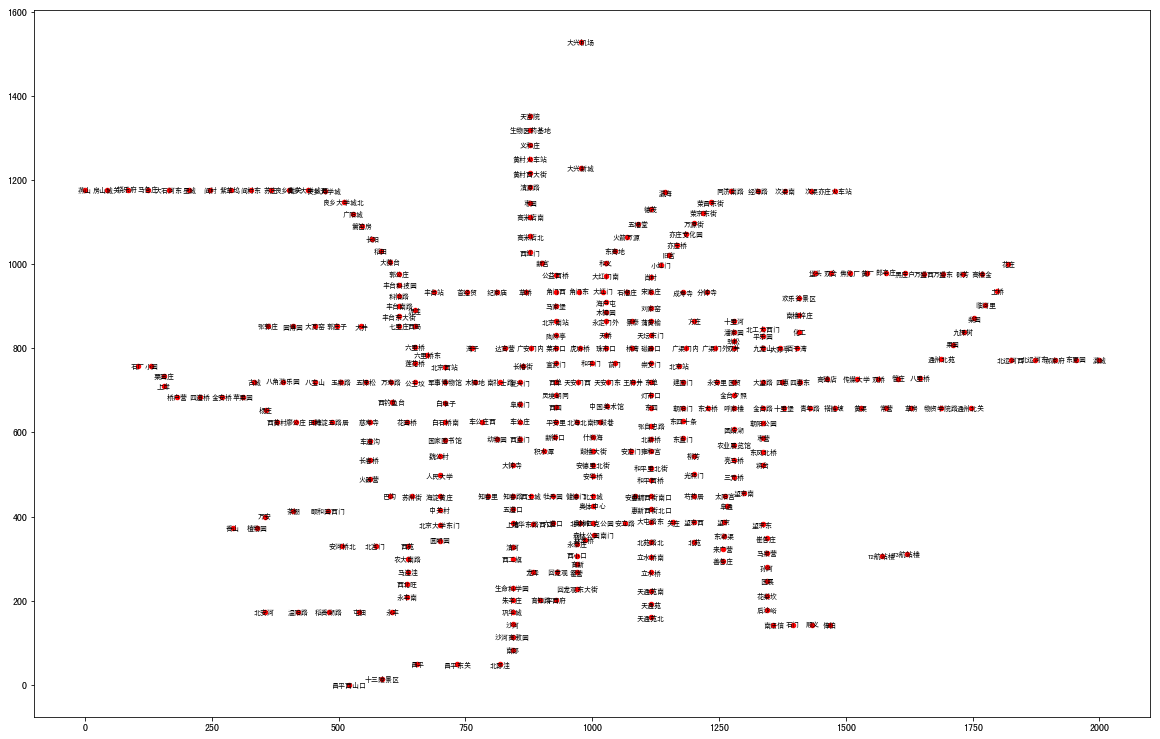

In [2]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family']='sans-serif'
matplotlib.rcParams['font.sans-serif']=['SimHei']


def get_lines_stations_info(text):
    #正则表达式取所有的站名、路线以及是否为环线
    #站名信息元组第1，2个为坐标与站名，后两个为空
    #线路信息元组前两个位空，第3，4个为线路名与是否循环
    s=re.compile('(?:rs\":\"([0-9\s]+).*?\"n\":\"(.*?)\")|(?:ln\":\"(.*?)\".*?lo\":\"(.*?)\")')
    lines_list=s.findall(s1)
    # 遍历text格式数据，组成地点数据结构
    # 所有线路信息的dict：key：线路名称；value：站点名称list
    lines_info = {}
    
    # 所有站点信息的dict：key：站点名称；value：站点坐标(x,y)
    stations_info = {}
    stationlist=[]
    
    
    for i in range(len(lines_list)):
        # 你可能需要思考的几个问题，获取「地铁线路名称，站点信息list，站名，坐标(x,y)，数据加入站点的信息dict，将数据加入地铁线路dict」
        if lines_list[i][-1]=='':
            stations_info[lines_list[i][1]]=tuple(map(int,lines_list[i][0].split(' ')))
            stationlist.append(lines_list[i][1])
        else:
                 #将路线名与是否为环线拼接在一起
                lines_info[lines_list[i][2]+lines_list[i][3]]=stationlist
                stationlist=[]
    return lines_info,stations_info

lines_info, stations_info = get_lines_stations_info(r.text)
#print(lines_info,stations_info)



# 根据线路信息，建立站点邻接表dict
def get_neighbor_info(lines_info):
    # 把str2加入str1站点的邻接表中
    def add_neighbor_dict(info, str1, str2):
        # 请在这里写代码
        if str1 not in info.keys():
            info[str1]=[]
        if str2 not in info.keys():
            info[str2]=[]
        info[str1].append(str2)
        info[str2].append(str1)
        
    neighbor_info={}
    for item in lines_info.items():
        for i in range(len(item[1])-1):
            add_neighbor_dict(neighbor_info,item[1][i],item[1][i+1])
            
    return neighbor_info
        
neighbor_info = get_neighbor_info(lines_info)
#print(neighbor_info)
                            
plt.figure(figsize=(20,13))
city_graph=nx.Graph()
city_graph.add_nodes_from(list(stations_info.keys()))
nx.draw_networkx_nodes(city_graph,stations_info, node_size=20,node_color='red')
nx.draw_networkx_labels(city_graph,stations_info,font_size=7)
col_list=['#b45b1f','#1fb4a6','#1f2db4','#b4a61f','#78b41f','#b41f78','#a61fb4','#b45b1f'\
         '#b45b1f','#1fb4a6','#1f2db4','#b4a61f','#78b41f','#b41f78','#a61fb4','#b45b1f']
for i,index in enumerate(neighbor_info):
    nx.draw_networkx_edges(city_graph, stations_info,edgelist=neighbor_info[index],width=2.5,edge_color=col_list[i]\
                          )
plt.show()   

In [ ]:
# 你可以用递归查找所有路径
def get_path_DFS_ALL(lines_info, neighbor_info, from_station, to_station):
    # 递归算法，本质上是深度优先
    # 遍历所有路径
    # 这种情况下，站点间的坐标距离难以转化为可靠的启发函数，所以只用简单的DFS算法
    # 检查输入站点名称
    res=get_next_station_DFS_ALL([{from_station},-1,[from_station]],neighbor_info,to_station)
    return res[-1]

def get_next_station_DFS_ALL(node, neighbor_info, to_station):
    res=[]
    if node[1]!=-1 and len(node[-1])>node[1]:
        return res
    if len(node[0])>54:
        return res
    if node[-1][-1]==to_station:
        node[1]=len(node[-1])
        return [node[-1].copy()]
    nextStations=neighbor_info[node[-1][-1]]
    for station in nextStations:
        if station not in node[0]:
            node[0].add(station)
            node[-1].append(station)
            res.extend(get_next_station_DFS_ALL(node,neighbor_info,to_station))
            node[0].remove(station)
            node[-1].pop()
    return res
res=get_path_DFS_ALL(lines_info,neighbor_info, '奥体中心', '天安门东')
print("DFS:",res)
